In [28]:
import numpy as np, os
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings(action='ignore')

#한글설정
import matplotlib.font_manager as fm

font_dirs = ['/usr/share/fonts/truetype/nanum', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    fm.fontManager.addfont(font_file)
    
# 한글 출력을 위해서 폰트 옵션을 설정합니다.
# "axes.unicode_minus" : 마이너스가 깨질 것을 방지

sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

In [29]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8513549521557792312]

# Method1
일관성, 방향성 고려한 feature 탐지 <br>
**goal : 사망/생존 마커 탐지** <br>
- Score 계산 식

<div align=center> $Score = ReLU(FI^{inverse})*sign(FI^{reverse})$ </div>

- $FI^{reverse}$
  1. X_test의 각 feature의 값(4068개)을 모두 1로 바꾸어 예측
  2. 예측값 리스트의 평균값 계산
  3. 각 feature의 평균값과 기존 baseline의 평균값을 계산 (= x)
    - x = mean(pred) - mean(y_test)
  4. x > 0 이면 1, x <= 0 이면 -1 으로 {1, -1}으로 부호 결정

# 필요한 데이터 로드

In [30]:
fi = pd.read_csv('./data/df_all_best_type.csv')
COLS = list(pd.read_csv('/project/LSH/total_data_7727.csv')['ITEMID'].sort_values().unique())
model = tf.keras.models.load_model('/project/LSH/model/(LSTM_best_4068)seed42-05-0.5029.hdf5')

# FI에 ReLU 적용

In [31]:
#relu 함수 정의
def relu(x):
    return np.maximum(0, x)

In [32]:
tmp = fi.copy()
tmp['diff'] = tmp['diff'].apply(lambda x:relu(x))
relu_fi = tmp[['feature', 'diff']].sort_values('diff', ascending=False)

In [36]:
relu_fi

,feature,diff
0,409606211,0.059180
1,74606211,0.036668
2,67434504,0.032467
3,54817525,0.029130
4,10019055302,0.027498
...,...,...
3469,78005303,0.000000
3470,17317001801,0.000000
3471,597003212,0.000000
3472,51435,0.000000


# all value 0 to 1 - mean(predict_list)

In [40]:
import random    
seed_num = 42
random.seed(seed_num)
path = '/project/LSH/'
X = np.load(path + 'x_(7727,10,4068).npy')
y = np.load(path + 'y_(7727,1).npy')

idx = list(range(len(X)))
random.shuffle(idx)


i = round(X.shape[0]*0.8)
X_train, y_train = X[idx[:i],:,:], y[idx[:i]]
X_test, y_test = X[idx[i:],:,:], y[idx[i:]]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6182, 10, 4068), (6182,), (1545, 10, 4068), (1545,))

In [41]:
base_pred = np.mean(model.predict(X_test))
base_pred

0.63693285

In [9]:
result = []
for i in tqdm(range(X_test.shape[2])):
    save_cols = X_test[:,:,i].copy()
    X_test[:,:,i] = 1
    pred = model.predict(X_test)
    result.append({'feature' : str(COLS[i]), 'value' : np.mean(pred)})
    #값 복원
    X_test[:,:,i] = save_cols

  0%|          | 0/4068 [00:00<?, ?it/s]

In [12]:
sign_fi = pd.DataFrame(result)
sign_fi_ori = sign_fi.copy()
sign_fi.sort_values('value', ascending=False)

,feature,value
2195,409606211,0.828592
1276,74606211,0.787280
1081,67434504,0.780401
982,54817525,0.770063
2744,10019055302,0.769281
...,...,...
162,51200,0.522870
3818,63323016101,0.522840
37,50889,0.521549
469,4003822,0.514280


In [37]:
# sign_fi.to_csv('./data/all_values_1.csv', index=False)
sign_fi = pd.read_csv('./data/all_values_1.csv')

In [42]:
sign_fi['baseline'] = base_pred
sign_fi['diff'] = sign_fi['value'] - sign_fi['baseline']

## Sign(부호) 추출

In [43]:
#부호 판별하여 1, -1로 변경하는 함수
def only_sign(x):
    if x >= 0:
        return 1
    else:
        return -1

In [44]:
sign_fi['sign'] = sign_fi['diff'].apply(lambda x:only_sign(x))
sign_fi = sign_fi.sort_values('feature')

In [45]:
sign_fi['sign'].value_counts()

 1    2117
-1    1951
Name: sign, dtype: int64

In [52]:
sign_fi

,feature,value,baseline,diff,sign
0,0,0.617007,0.636933,-0.019926,-1
1,50803,0.610828,0.636933,-0.026105,-1
2,50804,0.669560,0.636933,0.032628,1
3,50805,0.603049,0.636933,-0.033884,-1
4,50806,0.685344,0.636933,0.048411,1
...,...,...,...,...,...
4063,78112001103,0.587123,0.636933,-0.049810,-1
4064,79511050204,0.634779,0.636933,-0.002154,-1
4065,87701071218,0.725083,0.636933,0.088150,1
4066,87701083336,0.644183,0.636933,0.007250,1


# 최종 score 계산

In [57]:
relu_fi[relu_fi['feature']==409606211]
sign_fi[sign_fi['feature']==409606211]

,feature,value,baseline,diff,sign
2195,409606211,0.828592,0.636933,0.19166,1


In [62]:
result = sign_fi.feature.to_frame()
relu_fi = relu_fi.sort_values('feature').reset_index(drop=True)

result['score'] = relu_fi['diff'] * sign_fi['sign']
result = result.sort_values('score', ascending=False).reset_index(drop=True)
result

,feature,score
0,409606211,0.059180
1,74606211,0.036668
2,67434504,0.032467
3,54817525,0.029130
4,10019055302,0.027498
...,...,...
4063,51200,-0.016966
4064,182138167,-0.017109
4065,50889,-0.018246
4066,4003822,-0.019987


In [63]:
result.to_csv('./data/method1_score.csv', index=False)

# PRE PRO LAB 각 Top Feature 추출

In [64]:
result = pd.read_csv('./data/method1_score.csv')
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4068 entries, 0 to 4067
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   feature  4068 non-null   int64  
 1   score    4068 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 63.7 KB


In [65]:
merge_data = pd.read_csv('/project/guri/data/merge_data.csv')[['ITEM','Type']]

In [66]:
merge_data = merge_data.drop_duplicates().rename(columns = {'ITEM':'feature'})
# merge_data['feature'] = merge_data['feature'].astype('str')

In [67]:
merge_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4069 entries, 0 to 9204734
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   feature  4069 non-null   int64 
 1   Type     4069 non-null   object
dtypes: int64(1), object(1)
memory usage: 95.4+ KB


In [68]:
fi_type = pd.merge(result, merge_data, how='left', on='feature')
fi_type

,feature,score,Type
0,409606211,0.059180,PRE
1,74606211,0.036668,PRE
2,67434504,0.032467,PRE
3,54817525,0.029130,PRE
4,10019055302,0.027498,PRE
...,...,...,...
4063,51200,-0.016966,LAB
4064,182138167,-0.017109,PRE
4065,50889,-0.018246,LAB
4066,4003822,-0.019987,PRE


## Visualization Function

### 사망/퇴원 환자 df 분리

In [69]:
X = np.load('/project/LSH/x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')
# 컬럼이름 로드
COLS = list(pd.read_csv('/project/LSH/total_data_7727.csv')['ITEMID'].sort_values().unique())

#death_index
d_index = np.where(y==1)[0]
#survive_index (퇴원 환자)
s_index = np.where(y==0)[0]

#사망/퇴원 환자 분리
d_X = X[d_index]
s_X = X[s_index]

result = []
result_s = []
#day - 10일
for d in range(10):
    #4068 - ITEM
    for f in range(d_X.shape[-1]):
        d_sum = d_X[:,d,f].sum()/d_X.shape[0]
        s_sum = s_X[:,d,f].sum()/s_X.shape[0]
        result.append({'cols':COLS[f], 'day':10-d,'per':d_sum})
        result_s.append({'cols':COLS[f], 'day':10-d,'per':s_sum})
        
d_df = pd.DataFrame(result).sort_values(['cols','day']).reset_index(drop=True)
s_df = pd.DataFrame(result_s).sort_values(['cols','day']).reset_index(drop=True)
d_df.shape, s_df.shape

((40680, 3), (40680, 3))

In [70]:
def visualization(top10_list):
    plt.figure(figsize = (13,12), dpi=150)
    for i, f in enumerate(top10_list):
        plt.subplot(4,3,1+i)
        plt.title(f)
        ax = sns.lineplot(data = d_df[d_df['cols']==int(f)], x = 'day', y='per', label='사망')
        ax = sns.lineplot(data = s_df[s_df['cols']==int(f)], x = 'day', y='per', label='퇴원')
        ax.invert_xaxis()
        ax.legend(loc='upper left')
    plt.tight_layout()

## PRE

In [71]:
pre_top10 = fi_type[fi_type['Type']=='PRE'].feature[:10].to_list()
pre_top10

[409606211,
 74606211,
 67434504,
 54817525,
 10019055302,
 54858516,
 74706811,
 45006701,
 63323016501,
 58177025504]

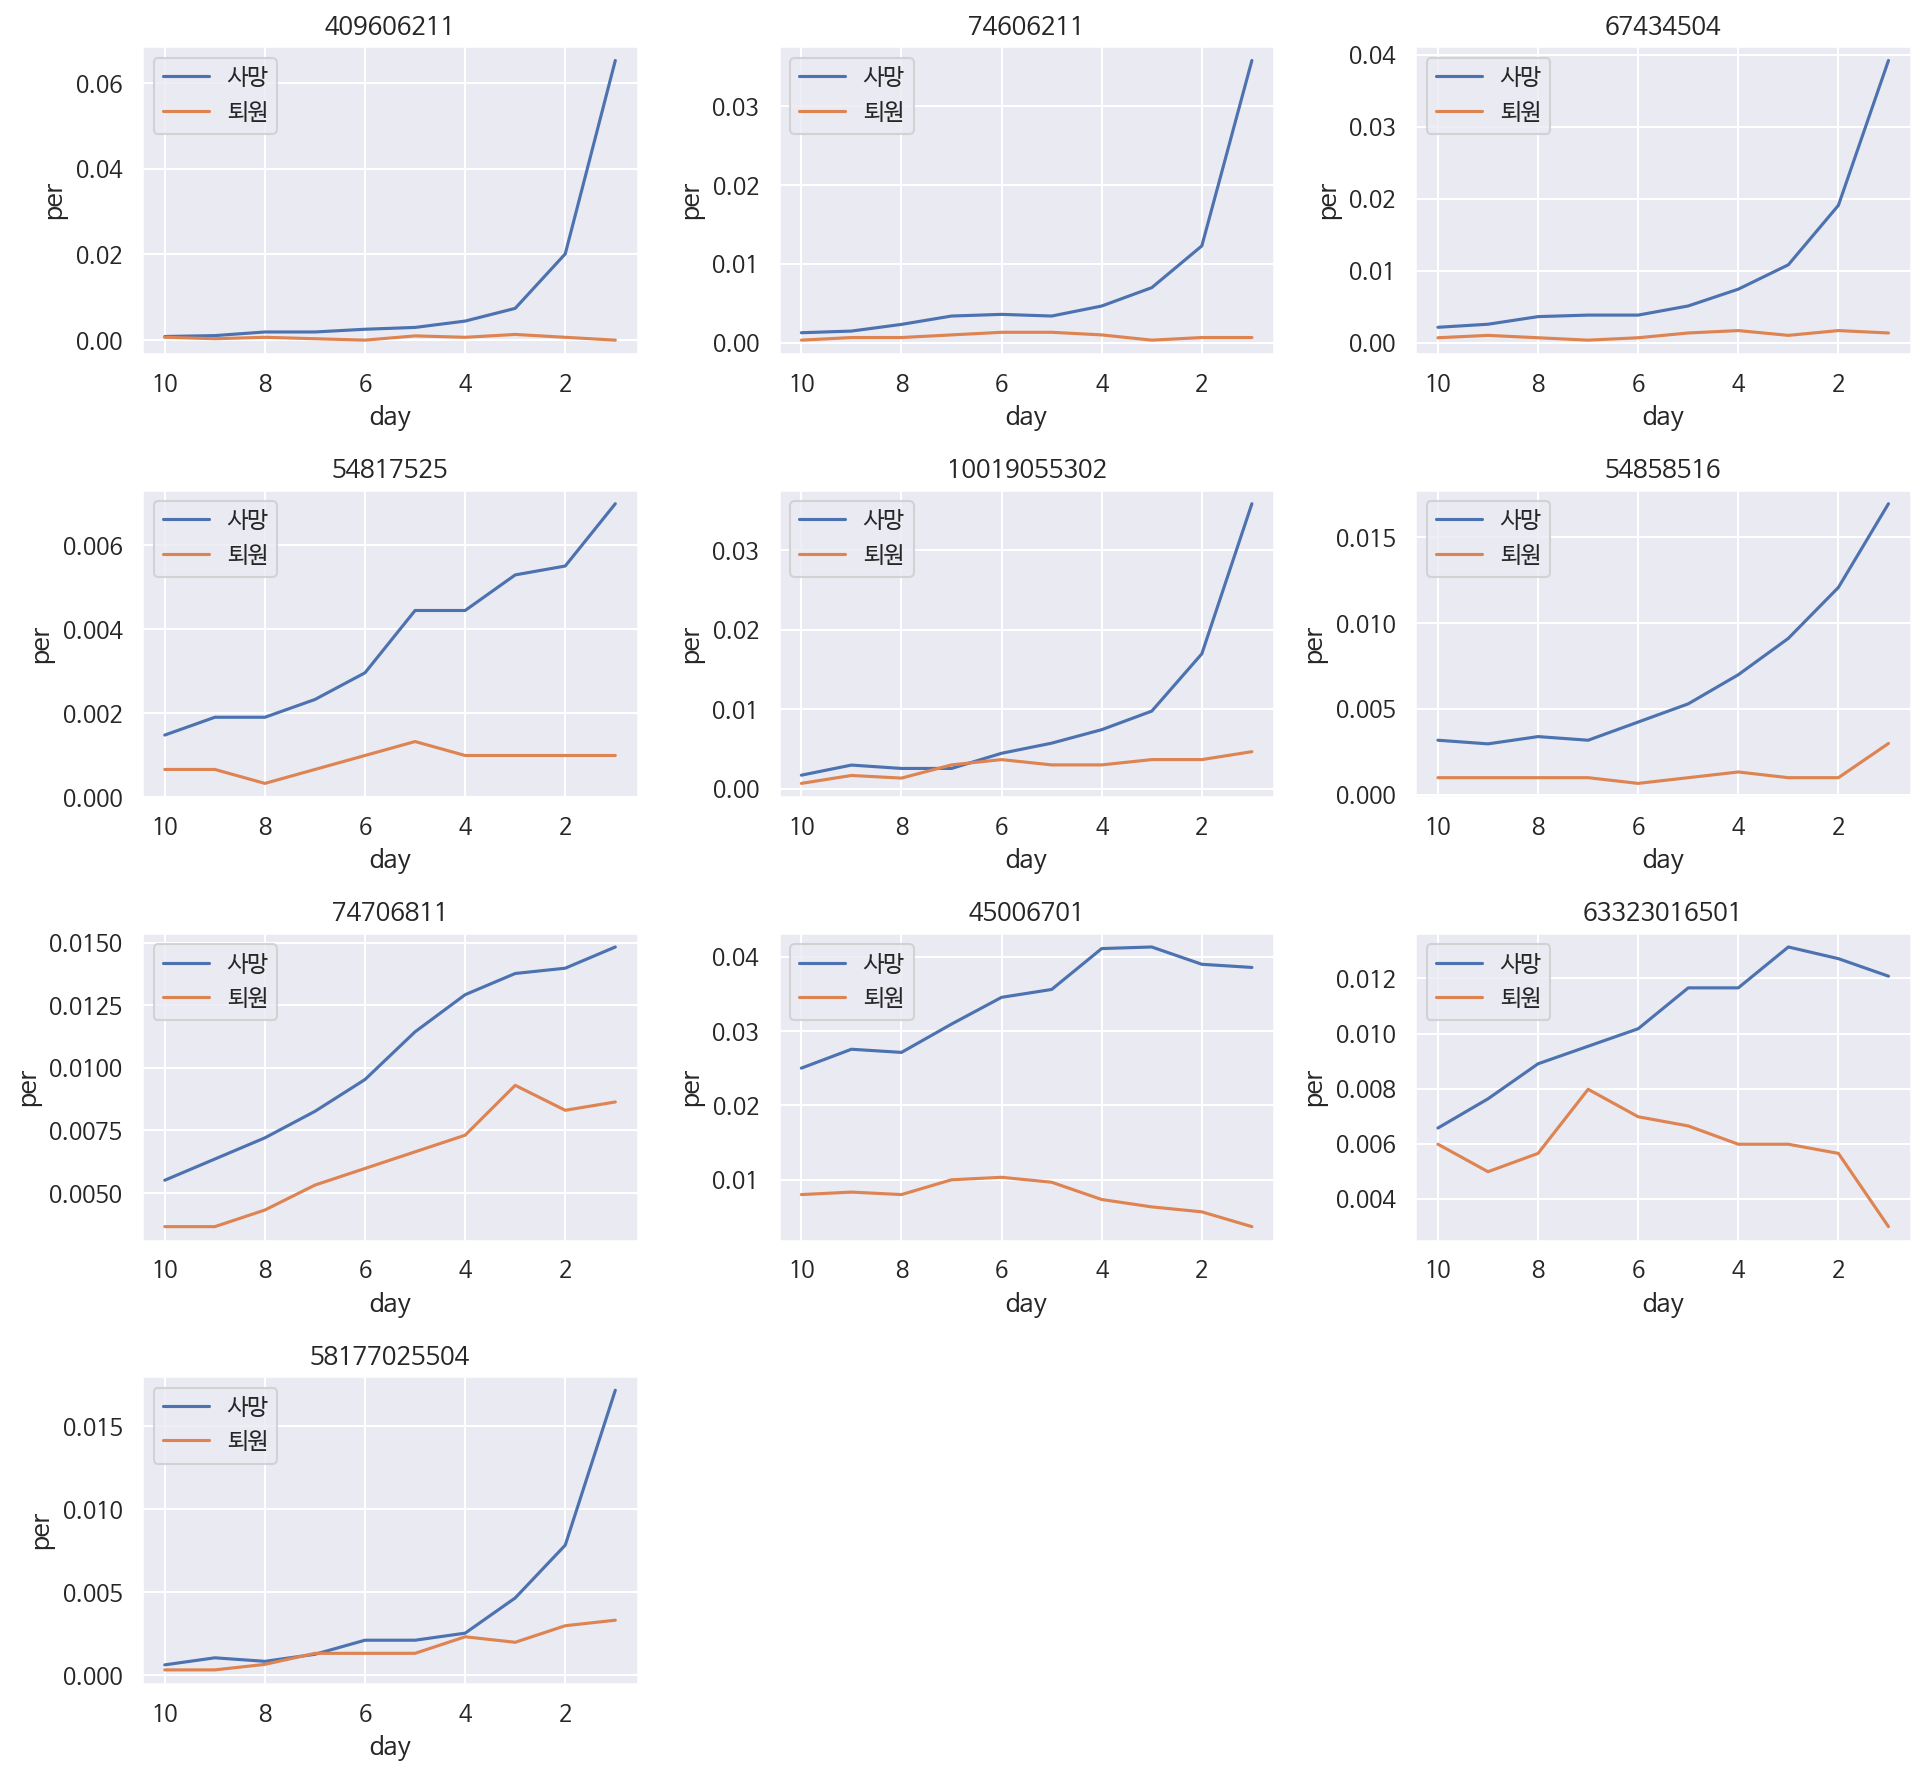

In [72]:
visualization(pre_top10)

## LAB

In [73]:
lab_top10 = fi_type[fi_type['Type']=='LAB'].feature[:10].to_list()
lab_top10

[51003, 51148, 50868, 50813, 51120, 50908, 51482, 50917, 50862, 50911]

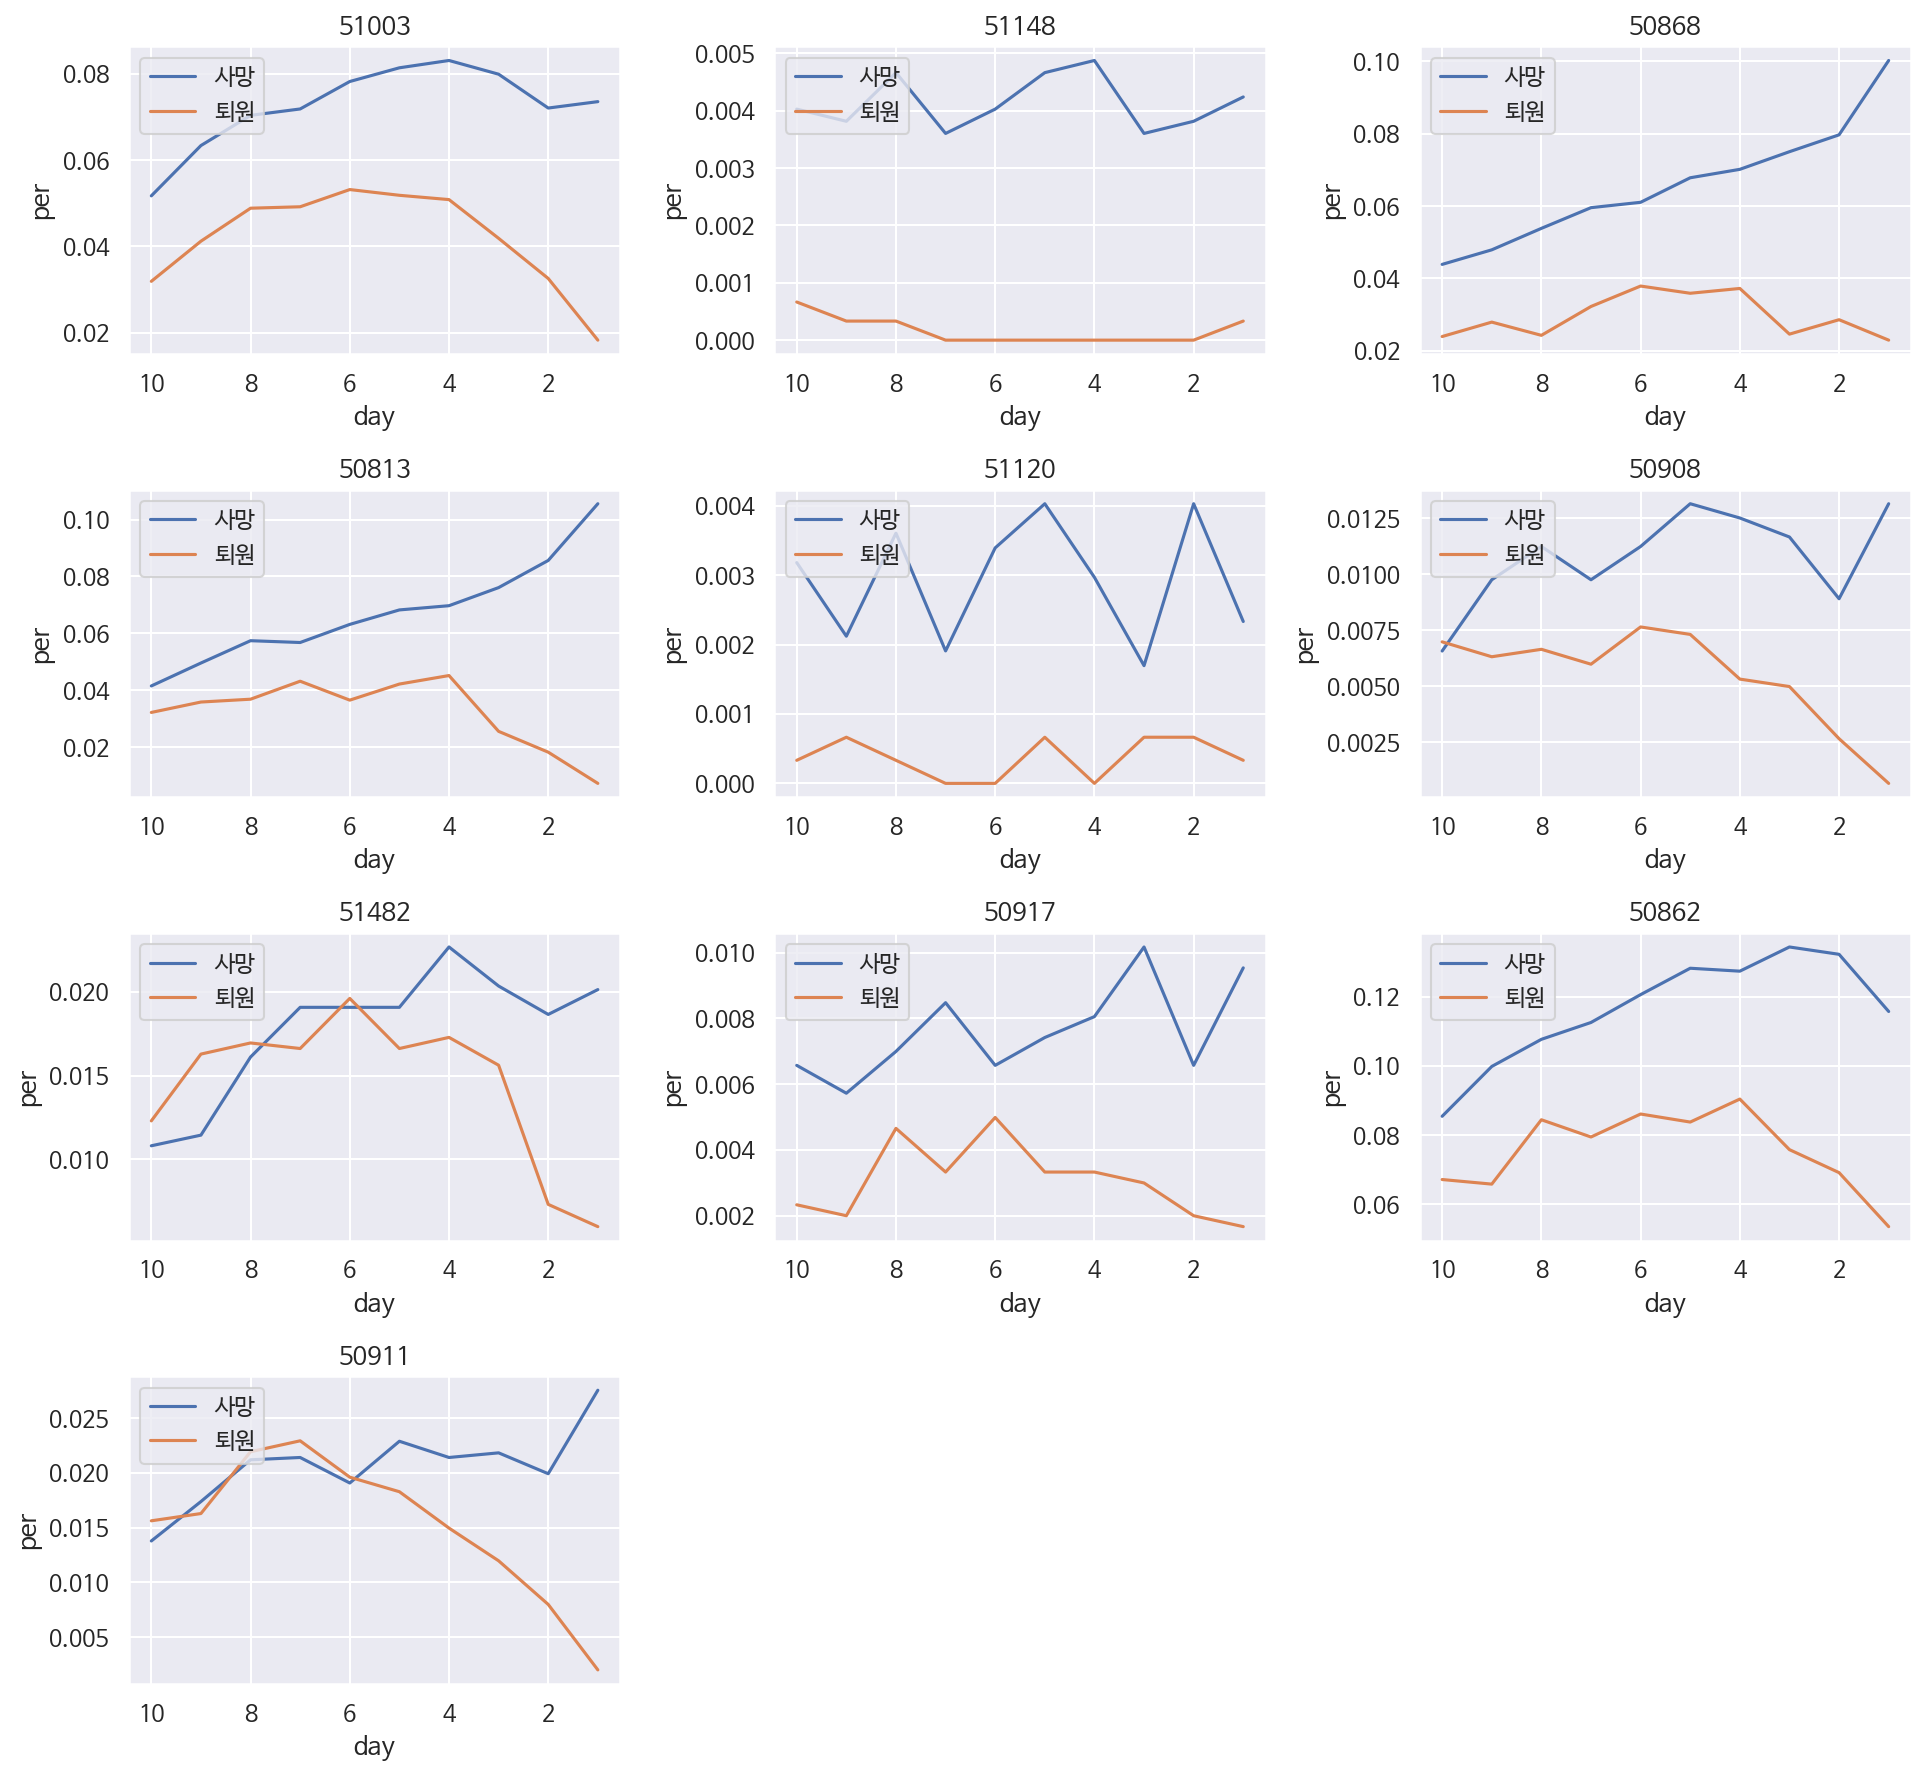

In [74]:
visualization(lab_top10)

## PRO

In [75]:
pro_top10 = fi_type[fi_type['Type']=='PRO'].feature[:10].to_list()
pro_top10

[228125,
 224270,
 225202,
 228127,
 228128,
 226124,
 225450,
 225794,
 228130,
 225802]

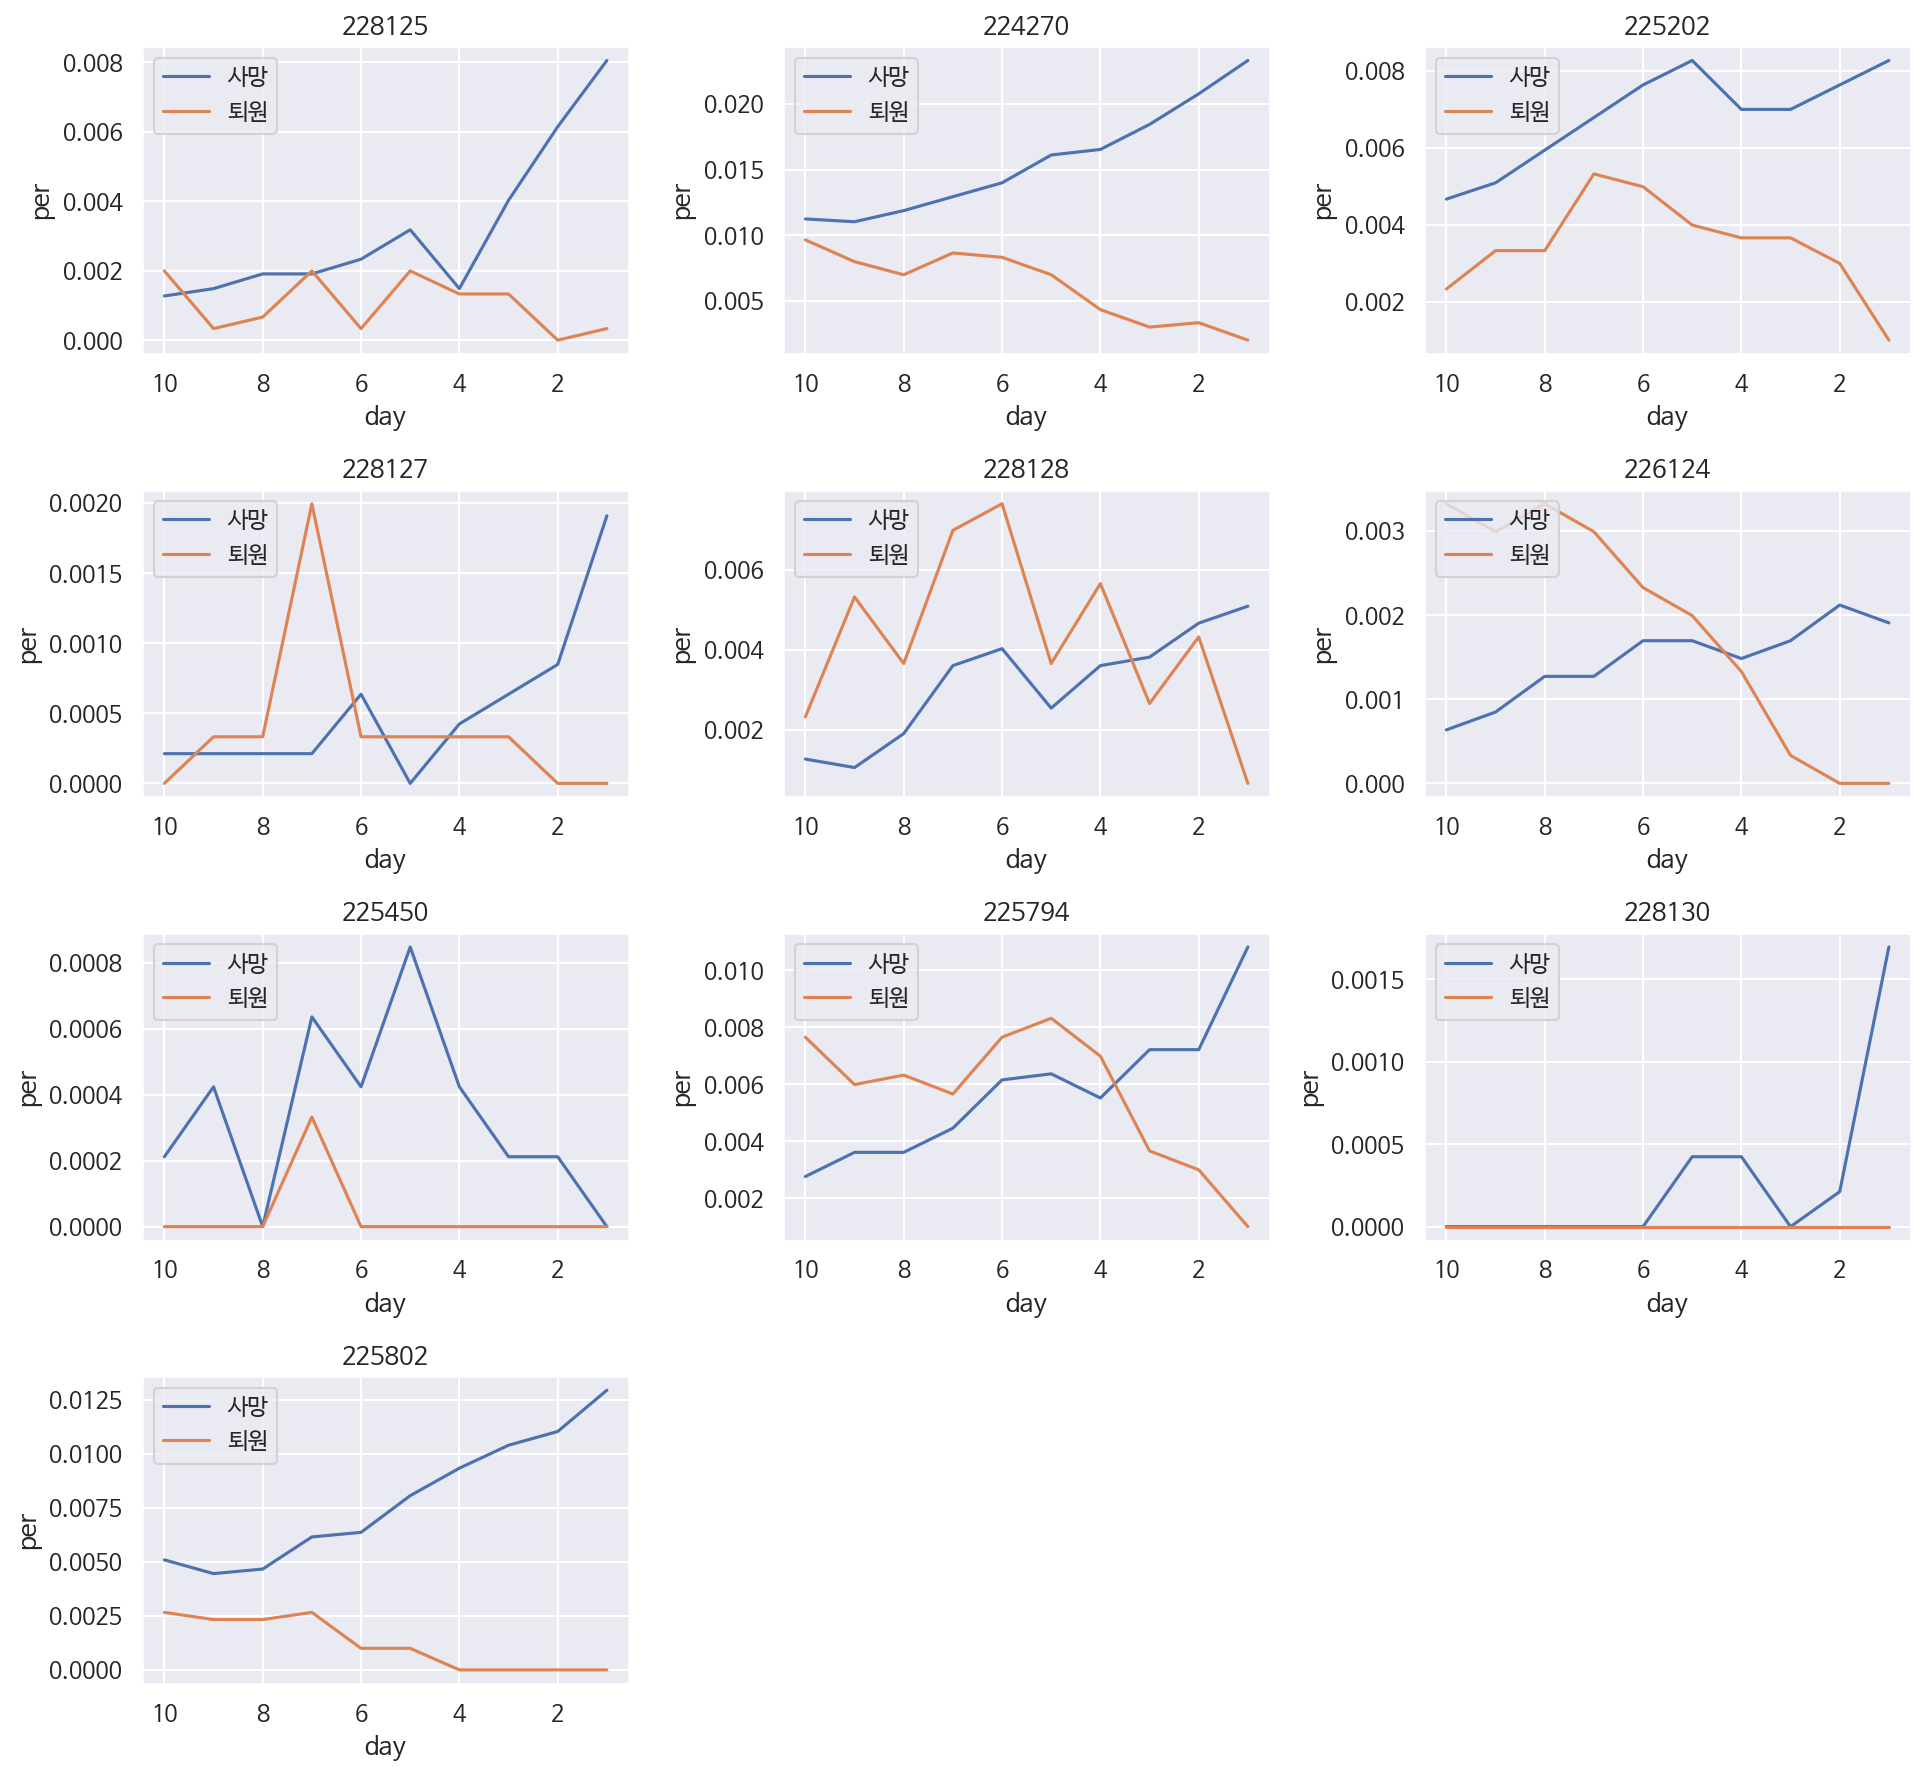

In [76]:
visualization(pro_top10)